In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


Hour_ahead = 48


GBMhourpreRMSE = []
GBMhourpreMAE = []
for a in range(Hour_ahead):

    hour_ahead = a+1
    n_estimators = 80
    learning_rate = 0.1
    Depth = 6
    Min_leaf = 20

    path = "/content/drive/MyDrive/Colab Notebooks/Project/No noise/NoiseMu0Sigma0.5.csv"
    Merge_all = pd.read_csv(path)
    dti = pd.to_datetime(Merge_all['DateTime'], format='%m/%d/%Y %H', exact=False)
    Merge_all.set_index(pd.Index(dti), inplace=True)
    Merge_all.drop(['DateTime'], axis=1, inplace=True)
    First = Merge_all.iloc[0:11000, :]
    N_index = First.shape
    Y_temp = First['FI']
    Y = Y_temp.iloc[hour_ahead:N_index[0]]
    Y = Y.to_numpy()

    X_temp1 = First['FI']
    X_temp2 = First.loc[:, First.columns != 'FI']
    X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
    X_temp2.set_index(X_temp2_index, inplace=True)
    X_temp1 = X_temp1.to_frame()
    X_temp = X_temp1.join(X_temp2)
    X = X_temp.iloc[0:N_index[0] - hour_ahead]
    X = X.to_numpy()
    Pred_index = X.shape
    print("Shape = "+str(Pred_index))



    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



    class DecisionTree():
        def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
            if idxs is None: idxs=np.arange(len(y))
            self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
            self.depth = depth
            #print(f_idxs)
            #         print(self.depth)
            self.n_features = n_features
            self.n, self.c = len(idxs), x.shape[1]
            self.val = np.mean(y[idxs])
            self.score = float('inf')
            self.find_varsplit()

        def find_varsplit(self):
            for i in self.f_idxs: self.find_better_split(i)
            if self.is_leaf: return
            x = self.split_col
            lhs = np.nonzero(x <= self.split)[0]
            rhs = np.nonzero(x > self.split)[0]
            lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)
            self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)

        def find_better_split(self, var_idx):
            x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
            sort_idx = np.argsort(x)
            sort_y, sort_x = y[sort_idx], x[sort_idx]
            rhs_sum2: object
            rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
            lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

            for i in range(0, self.n - self.min_leaf - 1):
                xi, yi = sort_x[i], sort_y[i]
                lhs_cnt += 1
                rhs_cnt -= 1
                lhs_sum += yi
                rhs_sum -= yi
                lhs_sum2 += yi ** 2
                rhs_sum2 -= yi ** 2
                if i < self.min_leaf or xi == sort_x[i + 1]:
                    continue

                lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
                rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
                curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
                if curr_score < self.score:
                    self.var_idx, self.score, self.split = var_idx, curr_score, xi

        @property
        def split_name(self):
            return self.x.columns[self.var_idx]

        @property
        def split_col(self):
            return self.x[self.idxs, self.var_idx]

        @property
        def is_leaf(self):
            return self.score == float('inf') or self.depth <= 0

        def predict(self, x):
            return np.array([self.predict_row(xi) for xi in x])

        def predict_row(self, xi):
            if self.is_leaf: return self.val
            t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
            return t.predict_row(xi)

    def std_agg(cnt, s1, s2):
        try:
            return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
        except:
            return 0

    xi = X_train
    train_index = X_train.shape
    yi = y_train - np.mean(y_train)
    ei = 0  # initialization of error
    predf = np.mean(y_train)  # initial prediction 0


    def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
        idxs = np.random.permutation(len(y))[:sample_sz]
        f_idxs = np.random.permutation(x.shape[1])[:n_features]
        return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                            idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


    print("hour_ahead = " + str(hour_ahead))
    print("n_estimators = " + str(n_estimators))
    print("learning_rate = " + str(learning_rate))
    print("Depth = " + str(Depth))
    print("Min_leaf = " + str(Min_leaf))


    trees = []
    for i in range(n_estimators):
        tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
        predi = tree.predict(xi)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
        ei = y_train - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop
        trees.append(tree)


    MSE = mean_squared_error(y_train, predf, squared=True)
    print("Training MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Training RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_train, predf)
    print("Training MAE  " + str(MAE))



    xi = X_test
    train_index = X_test.shape
    yi = y_test - np.mean(y_test)
    ei = 0  # initialization of error
    predf = np.mean(y_test)

    i = 0
    for t in trees:
        predi = t.predict(X_test)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
        ei = y_test - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop

        #if i == 6:
        #   break
        i += 1


    MSE = mean_squared_error(y_test, predf, squared=True)
    print("Testing MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Testing RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_test, predf)
    print("Testing MAE  " + str(MAE))

    GBMhourpreRMSE.append(RMSE)
    GBMhourpreMAE.append(MAE)

print(GBMhourpreRMSE)
print(GBMhourpreMAE)



เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
73  6.9014931522958936
74  6.901044465462794
75  6.898596410857843
76  6.9004417216668195
77  6.8981013183455735
78  6.897637507659995
79  6.898937950654577
Testing MSE  98.18717165681169
Testing RMSE  9.908944023295907
Testing MAE  6.898937950654577
Shape = (10980, 30)
hour_ahead = 20
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.206285198707228
1  6.872048997751118
2  6.592841481191543
3  6.370813881202004
4  6.1679672395731355
5  5.999870746165381
6  5.850972144884068
7  5.72677986087455
8  5.620198072956006
9  5.535951358478833
10  5.458296684070344
11  5.391407732672105
12  5.31516831140547
13  5.262258626322224
14  5.2051965110430745
15  5.169949094070941
16  5.140764351906188
17  5.11276422171031
18  5.072984888415034
19  5.039544710698474
20  5.014002016186744
21  4.988014278237485
22  4.967927190074512
23  4.946496768988936
24  4.929692572880354
25  4.914223952900789
26  4.899726903707236
27  4.88942

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


Hour_ahead = 48


GBMnoisehourpreRMSE = []
GBMnoisehourpreMAE = []
for a in range(Hour_ahead):

    hour_ahead = a+1
    n_estimators = 80
    learning_rate = 0.1
    Depth = 6
    Min_leaf = 20

    path = "/content/drive/MyDrive/Colab Notebooks/Project/NoiseMu0Sigma0.5.csv"
    Merge_all = pd.read_csv(path)
    dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
    Merge_all.set_index(pd.Index(dti), inplace=True)
    Merge_all.drop(['DateTime'], axis=1, inplace=True)
    First = Merge_all.iloc[0:11000, :]
    N_index = First.shape
    Y_temp = First['FI']
    Y = Y_temp.iloc[hour_ahead:N_index[0]]
    Y = Y.to_numpy()

    X_temp1 = First['FI']
    X_temp2 = First.loc[:, First.columns != 'FI']
    X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
    X_temp2.set_index(X_temp2_index, inplace=True)
    X_temp1 = X_temp1.to_frame()
    X_temp = X_temp1.join(X_temp2)
    X = X_temp.iloc[0:N_index[0] - hour_ahead]
    X = X.to_numpy()
    Pred_index = X.shape
    print("Shape = "+str(Pred_index))



    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



    class DecisionTree():
        def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
            if idxs is None: idxs=np.arange(len(y))
            self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
            self.depth = depth
            #print(f_idxs)
            #         print(self.depth)
            self.n_features = n_features
            self.n, self.c = len(idxs), x.shape[1]
            self.val = np.mean(y[idxs])
            self.score = float('inf')
            self.find_varsplit()

        def find_varsplit(self):
            for i in self.f_idxs: self.find_better_split(i)
            if self.is_leaf: return
            x = self.split_col
            lhs = np.nonzero(x <= self.split)[0]
            rhs = np.nonzero(x > self.split)[0]
            lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)
            self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)

        def find_better_split(self, var_idx):
            x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
            sort_idx = np.argsort(x)
            sort_y, sort_x = y[sort_idx], x[sort_idx]
            rhs_sum2: object
            rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
            lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

            for i in range(0, self.n - self.min_leaf - 1):
                xi, yi = sort_x[i], sort_y[i]
                lhs_cnt += 1
                rhs_cnt -= 1
                lhs_sum += yi
                rhs_sum -= yi
                lhs_sum2 += yi ** 2
                rhs_sum2 -= yi ** 2
                if i < self.min_leaf or xi == sort_x[i + 1]:
                    continue

                lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
                rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
                curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
                if curr_score < self.score:
                    self.var_idx, self.score, self.split = var_idx, curr_score, xi

        @property
        def split_name(self):
            return self.x.columns[self.var_idx]

        @property
        def split_col(self):
            return self.x[self.idxs, self.var_idx]

        @property
        def is_leaf(self):
            return self.score == float('inf') or self.depth <= 0

        def predict(self, x):
            return np.array([self.predict_row(xi) for xi in x])

        def predict_row(self, xi):
            if self.is_leaf: return self.val
            t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
            return t.predict_row(xi)

    def std_agg(cnt, s1, s2):
        try:
            return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
        except:
            return 0

    xi = X_train
    train_index = X_train.shape
    yi = y_train - np.mean(y_train)
    ei = 0  # initialization of error
    predf = np.mean(y_train)  # initial prediction 0


    def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
        idxs = np.random.permutation(len(y))[:sample_sz]
        f_idxs = np.random.permutation(x.shape[1])[:n_features]
        return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                            idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


    print("hour_ahead = " + str(hour_ahead))
    print("n_estimators = " + str(n_estimators))
    print("learning_rate = " + str(learning_rate))
    print("Depth = " + str(Depth))
    print("Min_leaf = " + str(Min_leaf))


    trees = []
    for i in range(n_estimators):
        tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
        predi = tree.predict(xi)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
        ei = y_train - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop
        trees.append(tree)


    MSE = mean_squared_error(y_train, predf, squared=True)
    print("Training MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Training RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_train, predf)
    print("Training MAE  " + str(MAE))



    xi = X_test
    train_index = X_test.shape
    yi = y_test - np.mean(y_test)
    ei = 0  # initialization of error
    predf = np.mean(y_test)

    i = 0
    for t in trees:
        predi = t.predict(X_test)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
        ei = y_test - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop

        #if i == 6:
        #   break
        i += 1


    MSE = mean_squared_error(y_test, predf, squared=True)
    print("Testing MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Testing RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_test, predf)
    print("Testing MAE  " + str(MAE))

    GBMnoisehourpreRMSE.append(RMSE)
    GBMnoisehourpreMAE.append(MAE)

print(GBMnoisehourpreRMSE)
print(GBMnoisehourpreMAE)



เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
73  7.443585152911218
74  7.44418971061979
75  7.44434638592173
76  7.4450026869445605
77  7.445724157386996
78  7.446251046896881
79  7.446358403893336
Testing MSE  113.7569190764572
Testing RMSE  10.665688870225738
Testing MAE  7.446358403893336
Shape = (10980, 30)
hour_ahead = 20
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.266216679896977
1  6.973398512391761
2  6.734750543559699
3  6.531123163075685
4  6.368365492899186
5  6.21964871553865
6  6.098764237499768
7  5.987170215234976
8  5.892277279197944
9  5.809745385509307
10  5.737588014496454
11  5.661145722165382
12  5.606074546095452
13  5.556150559142585
14  5.519602440373553
15  5.481664009797701
16  5.455800068866631
17  5.430348649813237
18  5.412478232711972
19  5.393100008676181
20  5.379618099450635
21  5.360375893152503
22  5.351750924463898
23  5.343445049586725
24  5.337127974723202
25  5.332133087258337
26  5.327535944667205
27  5.32457239

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


Hour_ahead = 48


GBMnoisehourpreRMSE2 = []
GBMnoisehourpreMAE2 = []
for a in range(Hour_ahead):

    hour_ahead = a+1
    n_estimators = 80
    learning_rate = 0.1
    Depth = 6
    Min_leaf = 20

    path = "/content/drive/MyDrive/Colab Notebooks/Project/No noise/NoiseMu0Sigma0.5.csv"
    Merge_all = pd.read_csv(path)
    dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
    Merge_all.set_index(pd.Index(dti), inplace=True)
    Merge_all.drop(['DateTime'], axis=1, inplace=True)
    First = Merge_all.iloc[0:11000, :]
    N_index = First.shape
    Y_temp = First['FI']
    Y = Y_temp.iloc[hour_ahead:N_index[0]]
    Y = Y.to_numpy()

    X_temp1 = First['FI']
    X_temp2 = First.loc[:, First.columns != 'FI']
    X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
    X_temp2.set_index(X_temp2_index, inplace=True)
    X_temp1 = X_temp1.to_frame()
    X_temp = X_temp1.join(X_temp2)
    X = X_temp.iloc[0:N_index[0] - hour_ahead]
    X = X.to_numpy()
    Pred_index = X.shape
    print("Shape = "+str(Pred_index))



    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



    class DecisionTree():
        def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
            if idxs is None: idxs=np.arange(len(y))
            self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
            self.depth = depth
            #print(f_idxs)
            #         print(self.depth)
            self.n_features = n_features
            self.n, self.c = len(idxs), x.shape[1]
            self.val = np.mean(y[idxs])
            self.score = float('inf')
            self.find_varsplit()

        def find_varsplit(self):
            for i in self.f_idxs: self.find_better_split(i)
            if self.is_leaf: return
            x = self.split_col
            lhs = np.nonzero(x <= self.split)[0]
            rhs = np.nonzero(x > self.split)[0]
            lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
            self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)
            self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                    min_leaf=self.min_leaf)

        def find_better_split(self, var_idx):
            x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
            sort_idx = np.argsort(x)
            sort_y, sort_x = y[sort_idx], x[sort_idx]
            rhs_sum2: object
            rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
            lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

            for i in range(0, self.n - self.min_leaf - 1):
                xi, yi = sort_x[i], sort_y[i]
                lhs_cnt += 1
                rhs_cnt -= 1
                lhs_sum += yi
                rhs_sum -= yi
                lhs_sum2 += yi ** 2
                rhs_sum2 -= yi ** 2
                if i < self.min_leaf or xi == sort_x[i + 1]:
                    continue

                lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
                rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
                curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
                if curr_score < self.score:
                    self.var_idx, self.score, self.split = var_idx, curr_score, xi

        @property
        def split_name(self):
            return self.x.columns[self.var_idx]

        @property
        def split_col(self):
            return self.x[self.idxs, self.var_idx]

        @property
        def is_leaf(self):
            return self.score == float('inf') or self.depth <= 0

        def predict(self, x):
            return np.array([self.predict_row(xi) for xi in x])

        def predict_row(self, xi):
            if self.is_leaf: return self.val
            t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
            return t.predict_row(xi)

    def std_agg(cnt, s1, s2):
        try:
            return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
        except:
            return 0

    xi = X_train
    train_index = X_train.shape
    yi = y_train - np.mean(y_train)
    ei = 0  # initialization of error
    predf = np.mean(y_train)  # initial prediction 0


    def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
        idxs = np.random.permutation(len(y))[:sample_sz]
        f_idxs = np.random.permutation(x.shape[1])[:n_features]
        return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                            idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


    print("hour_ahead = " + str(hour_ahead))
    print("n_estimators = " + str(n_estimators))
    print("learning_rate = " + str(learning_rate))
    print("Depth = " + str(Depth))
    print("Min_leaf = " + str(Min_leaf))


    trees = []
    for i in range(n_estimators):
        tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
        predi = tree.predict(xi)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
        ei = y_train - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop
        trees.append(tree)


    MSE = mean_squared_error(y_train, predf, squared=True)
    print("Training MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Training RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_train, predf)
    print("Training MAE  " + str(MAE))



    xi = X_test
    train_index = X_test.shape
    yi = y_test - np.mean(y_test)
    ei = 0  # initialization of error
    predf = np.mean(y_test)

    i = 0
    for t in trees:
        predi = t.predict(X_test)
        predf = predf + learning_rate * predi
        print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
        ei = y_test - predf  # needed originl y here as residual always from original y
        yi = ei  # update yi as residual to reloop

        #if i == 6:
        #   break
        i += 1


    MSE = mean_squared_error(y_test, predf, squared=True)
    print("Testing MSE  " + str(MSE))
    RMSE = np.sqrt(MSE)
    print("Testing RMSE  " + str(RMSE))
    MAE = mean_absolute_error(y_test, predf)
    print("Testing MAE  " + str(MAE))

    GBMnoisehourpreRMSE2.append(RMSE)
    GBMnoisehourpreMAE2.append(MAE)

print(GBMnoisehourpreRMSE2)
print(GBMnoisehourpreMAE2)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
73  6.023403343480193
74  6.0294023658914515
75  6.042218854156637
76  6.034150184954524
77  6.037782225619723
78  6.039906231577705
79  6.041136390181545
Testing MSE  82.93012563622493
Testing RMSE  9.106597917786035
Testing MAE  6.041136390181545
Shape = (10980, 30)
hour_ahead = 20
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.2150158185629625
1  6.889256222157698
2  6.618330971070049
3  6.389606388357611
4  6.20079368023719
5  6.042567333062407
6  5.914078008794812
7  5.793586862411145
8  5.686663872230406
9  5.594835721680626
10  5.5179952337561335
11  5.4558407629845815
12  5.40269124606695
13  5.353930965831977
14  5.310960620855421
15  5.277511510880741
16  5.246229855652114
17  5.222133386931057
18  5.201599718030734
19  5.18302254702825
20  5.165816976109502
21  5.146705123277158
22  5.1295699729680315
23  5.118484277567192
24  5.11149240492487
25  5.09920362906097
26  5.089174609341571
27  5.0776158

In [ ]:
GBMhourpreRMSE = [8.878029146291915, 10.054782726576706, 9.953684694570244, 10.391777988374349, 10.154666412630986, 10.048477624825932, 9.300895618591811, 9.601589004499758, 8.99157447991958, 8.96948839016756, 9.650787079420759, 10.2633791060257, 9.960681178452644, 10.742018287596485, 10.413224061663069, 9.846715723861982, 9.695491894262808, 9.879441439461493, 9.908944023295907, 9.72084542533832, 9.253464287345524, 8.604099930337588, 7.92754728224972, 8.203249302525755, 9.192928342886239, 10.258945159000865, 10.285675469931023, 10.300683471463822, 10.225446881027931, 10.120486969785874, 10.183909814374088, 9.467285479864065, 9.934043005206087, 9.3047719714711, 10.495476207064522, 11.585912590424465, 10.664991100735854, 10.103776673007665, 10.08522208231126, 10.322180531322065, 10.29460246605822, 9.763630449481623, 10.477811832254021, 9.764535046753288, 9.63018545884737, 9.551806907494203, 8.790283381171822, 8.7423108239416]
GBMhourpreMAE = [6.460508623542239, 7.095626575401432, 6.982282379510361, 7.184003679341994, 7.2266480385374505, 7.227829189377735, 6.573022392307725, 6.785802729020851, 6.165495347273155, 6.239518310142007, 6.840608580861754, 7.384740237963771, 7.068094818459965, 7.701429160526024, 7.281592824015246, 7.097205270359762, 7.044749957005411, 6.982828538137621, 6.898937950654577, 6.8512365807610065, 6.405961828523463, 5.829679607999221, 5.2277661386297005, 5.437284329218191, 6.323798727874938, 7.25922075201361, 7.058568473202755, 7.280938060592166, 7.189264357022051, 7.088983847962201, 7.233624236328536, 6.797890773486084, 7.127765322561218, 6.378424192411361, 7.206772329950419, 7.928766633990113, 7.309177942822925, 7.121574778943457, 7.143433753854652, 7.214077446932869, 7.246285724461561, 7.0072424524159365, 7.072421719379939, 6.6988236784592825, 6.505207198458634, 6.615908924240365, 5.956096084976713, 6.073293795061782]

In [ ]:
GBMnoisehourpreRMSE = [9.262000593853516, 10.22825630754202, 10.367533863124272, 11.079894218087047, 10.564005195460263, 10.55073287254958, 10.782737808081821, 10.860524062524377, 11.191192757615523, 11.336394215475488, 11.956571936765087, 12.008130268354101, 11.786721021009646, 11.277189906398997, 11.265453960466052, 11.36142069510341, 11.544855291887465, 10.987700339415685, 10.665688870225738, 10.226854557752805, 9.526350016258837, 8.879658663123005, 8.272436407049641, 8.557376641355965, 9.376950347840069, 9.623642448190784, 10.06390149537398, 10.42074078420062, 10.547576156173047, 10.586855603975014, 10.624558356423814, 10.71069228530523, 10.884071845501499, 11.124637998350213, 11.183719706432951, 11.599182130612693, 11.287982559423764, 11.066995106688553, 10.884048954609838, 10.784466344735035, 11.017687130466152, 10.72275100747287, 10.6095760036679, 11.029453702328004, 10.259153175555623, 9.63653729038748, 9.34997928708333, 9.63544040204511]
GBMnoisehourpreMAE = [6.802336939699931, 7.087048057359898, 7.076391609998343, 7.943118522495489, 7.588237545736187, 7.554340642585469, 7.766187368797999, 7.810072216642508, 8.010651215358699, 8.111908145941271, 8.64085318843457, 8.696820561129423, 8.654982405826528, 8.356652794854686, 8.321905134525185, 8.369779379815355, 8.416499240583557, 7.8977736151348745, 7.446358403893336, 7.040488398465195, 6.453909430118845, 5.926746294110967, 5.56288950655542, 5.662851027818522, 6.5922501224208085, 6.845056646622379, 7.469478255192293, 7.79416991874488, 8.067302795342352, 8.024228730651759, 7.996537661877812, 8.001301283788083, 8.05290163291103, 8.220692411570967, 8.292830367730122, 8.668868718398176, 8.394316690232516, 8.184035217215628, 8.144266132774163, 7.968938954714329, 8.221316326345692, 7.552301396621203, 7.380999222199098, 7.496864350314543, 7.014413360601312, 6.450732111397536, 6.148113003540187, 6.381680412780985]

In [ ]:
#Mu0Sigma0.5
GBMnoisehourpreRMSE2 = [12.146870250870922, 11.237398477531618, 10.129576663108704, 9.796022644333057, 9.507034729372064, 9.660946939260262, 9.880136703413452, 9.163547995717307, 9.811023546831326, 9.450651590275172, 9.536390265289988, 9.474100979664374, 9.792855604446457, 9.690327659595656, 10.140325744093085, 9.621603582061283, 9.616281866162057, 9.71197231386353, 9.106597917786035, 8.561445119122487, 8.377720640305224, 8.538298648003682, 9.520767244706088, 10.124511933177997, 10.530495036307654, 10.211978745629201, 9.670785155381756, 9.567326347441362, 9.316507627679545, 9.452043788683362, 9.577575815171773, 9.682739861396467, 9.78737048687605, 9.699630014587747, 9.61854240014574, 9.648265750782954, 9.796726521599924, 10.301299278720656, 9.680278218530077, 9.503165984145035, 9.412973318827087, 9.442754459744878, 9.310742298399703, 9.355313459311512, 10.412020519276405, 9.68880470219586, 9.64844252108514, 10.106770861998003]
GBMnoisehourpreMAE2 = [8.669161314947546, 7.8683184192070454, 7.097380387568748, 6.90312950565545, 6.725449938530998, 6.795901766962439, 7.172088157354103, 6.475975944063401, 6.829922729630082, 6.612494404662498, 6.8818413736377515, 6.795165019103682, 7.036818334487785, 6.956818235127244, 7.072019218483496, 6.854397859784954, 6.75089986621314, 6.807477708675402, 6.041136390181545, 5.507209606924907, 5.238592732352538, 5.604931136217758, 6.413320892995153, 6.917205968375426, 7.475277115677493, 7.433059554297952, 6.961962801464267, 6.688892701278364, 6.572596075687299, 6.651876664774395, 6.6636623900261815, 6.747175566169813, 6.71099619449075, 6.755490400532883, 6.835410825110564, 6.965721499109911, 7.036561772051949, 7.202067393094808, 6.812049303019364, 6.615408724943525, 6.545663011752242, 6.4360124356194985, 6.272526485380414, 6.161928187321663, 6.5801466722151405, 6.6473967732876895, 6.534482536436104, 6.8559956494604615]

In [ ]:
#Mu0Sigma2
GBMnoisehourpreRMSE3 = [12.2827346828345, 11.775184959224584, 10.855603716938619, 10.425689731619563, 9.767367704162863, 9.69208629154313, 9.612942594116326, 10.061358065035234, 10.574116076584076, 10.563141254533434, 9.707698437795234, 10.23505869709366, 10.044693852946498, 9.886075063407004, 9.841606300977784, 9.832257790250384, 9.69784173564187, 9.479674296941552, 9.254934081950294, 8.47476507149795, 8.117812352238387, 8.598001049775142, 9.323432591398376, 10.199715772145518, 10.416074324139458, 10.220665716210192, 9.617374409323869, 9.683485294246857, 9.532201133770096, 9.485375522600322, 9.568176518266364, 9.800220413032157, 9.907859671015414, 10.094128804989166, 9.983505102023122, 10.0833204201225, 10.04613443107047, 9.681120282747113, 9.691863760130795, 9.477805914466586, 9.573022812201707, 9.208837682883479, 9.151040131817464, 8.999720149547796, 9.111256901755965, 9.326285589381454, 9.789931984664632, 10.273663313156332]
GBMnoisehourpreMAE3 = [8.83043406932455, 8.277317777234208, 7.5403024141091635, 7.268377729643619, 6.854184855895062, 6.8615791570115165, 6.9193740701792095, 7.123745382302379, 7.419938227425162, 7.460191589638504, 6.844844279865576, 7.230180002425556, 7.019036375360617, 6.85862778651534, 6.886630857516657, 7.055036573438218, 6.777584267968394, 6.630376227348476, 6.190048911707489, 5.503804081525019, 5.090097204371869, 5.540950705636125, 6.094468520192581, 6.897941142638751, 7.181390530351225, 7.155558000286467, 6.683759356048048, 6.78040043446433, 6.693389326324428, 6.692211751130831, 6.739435796546623, 6.869414785000413, 6.933338209327104, 7.098990934110317, 7.024770779671437, 7.020889870588318, 6.971263528363435, 6.8836426490633755, 6.847251224449621, 6.781491735178192, 6.8254793383779955, 6.377553686260769, 6.2129458013652705, 5.901778675340677, 5.916088196274899, 6.0926650888500165, 6.456620181024549, 6.7616689695412155]

In [ ]:
#Mu2Sigma1
GBMnoisehourpreRMSE4 = [12.156861261689587, 11.401856262291632, 10.677824266563283, 9.991796177462, 9.749853920474655, 9.744862905807798, 9.515100287908608, 9.934566264879352, 9.976517153129313, 10.061719666772836, 9.683323094324592, 9.715824825755826, 9.561181418927438, 9.691043501225423, 9.619495818562845, 9.64372788882516, 9.514133625297937, 9.444832470838126, 8.793773819985741, 8.4307709679541, 8.096973231705679, 8.53909782200019, 9.337251054554525, 10.13594149948582, 10.2063013199016, 9.973605777226492, 9.685443618616729, 9.337595512133408, 9.305906050052856, 9.289228768769876, 9.282722555081342, 9.45880108384019, 9.671496112660721, 9.620640438215675, 9.553149808830899, 9.499844415232817, 9.876400773216542, 9.644374688854569, 9.448469244790108, 9.438458786186029, 9.249928167479815, 9.138364754160083, 9.152673827076681, 8.829011106388164, 9.096285568497072, 9.304643976920561, 9.684466026510457, 10.1892926949367]
GBMnoisehourpreMAE4 = [8.668067058600252, 7.9870604618298255, 7.462633209412372, 7.022119914267941, 6.92375540056439, 6.869157160017404, 6.800010785679099, 7.190572427121193, 6.940938455957456, 7.125187853867988, 6.942413877046874, 6.896400855787116, 6.798426027664348, 6.895771407548695, 6.9125096166258855, 6.961276063601662, 6.723613736654229, 6.442140868105415, 5.889445743996688, 5.574611861318627, 5.023326872671477, 5.549652911051944, 6.2597272027642, 6.793745681964126, 7.1099501998020145, 7.057345051285606, 6.913480551046248, 6.659992722976967, 6.6046270073144475, 6.716741065967659, 6.612189396607073, 6.677937527585347, 6.853512808496315, 6.813392141412087, 6.741522364239679, 6.797710919259667, 6.98040740836717, 6.899243514508553, 6.835795213206008, 6.670726505669923, 6.575868331217119, 6.263893294259327, 6.2418311539572855, 5.789333166307833, 6.007205978129647, 6.097125938580804, 6.462197915551434, 6.764233062567079]

In [ ]:
#Mu-2Sigma1
GBMnoisehourpreRMSE5 = [12.275023797136953, 11.69697109233357, 10.827159206192169, 10.089689979842756, 9.55313436148254, 9.668671793338966, 9.798453833107015, 10.070727892171558, 10.632637145138201, 10.290471758948732, 9.845414691367681, 9.62547335280182, 9.685715798963058, 9.495071690655223, 9.808643594187156, 9.586674900821643, 9.610952924417491, 9.245628633473636, 8.87415187396913, 8.351043943247964, 7.955006684925782, 8.450457791319613, 9.292824909022729, 10.226411671866366, 10.547587664501236, 10.432313793430398, 10.02670325492168, 9.86202219948613, 9.551716208150149, 9.648749675609317, 9.504951026554574, 9.718773284373256, 10.096051966987508, 10.183977474349565, 9.936884757850699, 9.801213210822807, 9.767527372454424, 9.671184068261118, 9.514610278859488, 9.503531558122525, 9.211484266546769, 9.042791955811497, 9.064714010384053, 8.89804299774943, 8.928245950828774, 9.257060619234508, 9.819276844063156, 10.272584311262415]
GBMnoisehourpreMAE5 = [8.759573292702566, 8.267803524985876, 7.463995470880873, 7.038361497704887, 6.7143255019980375, 6.7773847213221385, 6.841613875639531, 7.099446376035438, 7.418609462861803, 7.246671079919888, 7.1370625910448, 6.9158823809060115, 6.869624094780919, 6.668788915053667, 6.9188391686790895, 6.9407993831008135, 6.811411474355187, 6.375287400226567, 5.934640014782236, 5.42642706932341, 4.940699243987937, 5.524386839012232, 6.1549918365910745, 6.852077110544203, 7.3480782732734475, 7.3259375184977, 6.938599725384869, 6.859283020328532, 6.671179476891141, 6.740940883234529, 6.649124882105481, 6.911293150482827, 7.106847927919648, 7.097863235730348, 6.98550620504733, 6.95007909333535, 6.876902833417403, 6.851010999565637, 6.889592763206113, 6.963195765749643, 6.49473616267865, 6.2757050068753255, 6.13451364075682, 5.981195100351278, 5.831743666302904, 6.150570820850646, 6.52692120138468, 6.866168344595988]

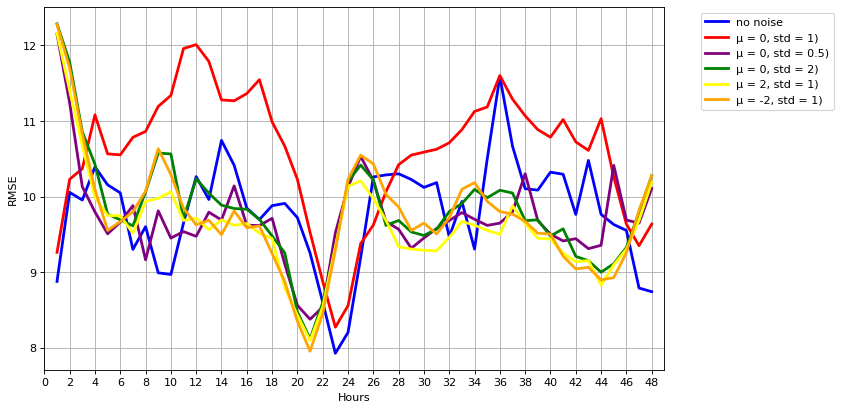

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Hour_ahead = 48

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(len(GBMhourpreRMSE))+1, GBMhourpreRMSE, color="blue", linewidth=2.5, linestyle="-", label='no noise')
plt.plot(np.arange(len(GBMnoisehourpreRMSE))+1, GBMnoisehourpreRMSE, color="red", linewidth=2.5, linestyle="-", label='\u03BC = 0, std = 1)')
plt.plot(np.arange(len(GBMnoisehourpreRMSE2))+1, GBMnoisehourpreRMSE2, color="purple", linewidth=2.5, linestyle="-", label='\u03BC = 0, std = 0.5)')
plt.plot(np.arange(len(GBMnoisehourpreRMSE3))+1, GBMnoisehourpreRMSE3, color="green", linewidth=2.5, linestyle="-", label='\u03BC = 0, std = 2)')
plt.plot(np.arange(len(GBMnoisehourpreRMSE4))+1, GBMnoisehourpreRMSE4, color="yellow", linewidth=2.5, linestyle="-", label='\u03BC = 2, std = 1)')
plt.plot(np.arange(len(GBMnoisehourpreRMSE5))+1, GBMnoisehourpreRMSE5, color="orange", linewidth=2.5, linestyle="-", label='\u03BC = -2, std = 1)')
plt.xlabel('Hours')
plt.ylabel('RMSE')
plt.grid(linestyle='-')
plt.xlim(0, Hour_ahead+1)  
plt.xticks(np.arange(0, len(GBMhourpreRMSE)+1, 2.0))
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

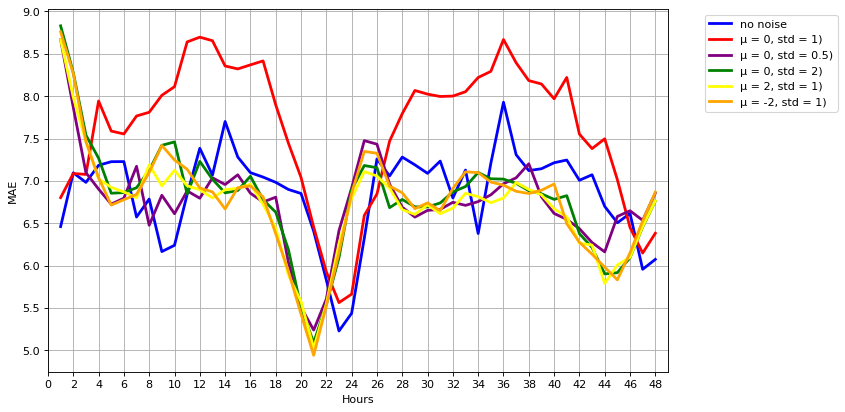

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(len(GBMhourpreMAE))+1, GBMhourpreMAE, color="blue", linewidth=2.5, linestyle="-", label='no noise')
plt.plot(np.arange(len(GBMnoisehourpreMAE))+1, GBMnoisehourpreMAE, color="red", linewidth=2.5, linestyle="-", label='\u03BC = 0, std = 1)')
plt.plot(np.arange(len(GBMnoisehourpreMAE2))+1, GBMnoisehourpreMAE2, color="purple", linewidth=2.5, linestyle="-", label='\u03BC = 0, std = 0.5)')
plt.plot(np.arange(len(GBMnoisehourpreMAE3))+1, GBMnoisehourpreMAE3, color="green", linewidth=2.5, linestyle="-", label='\u03BC = 0, std = 2)')
plt.plot(np.arange(len(GBMnoisehourpreMAE4))+1, GBMnoisehourpreMAE4, color="yellow", linewidth=2.5, linestyle="-", label='\u03BC = 2, std = 1)')
plt.plot(np.arange(len(GBMnoisehourpreMAE5))+1, GBMnoisehourpreMAE5, color="orange", linewidth=2.5, linestyle="-", label='\u03BC = -2, std = 1)')
plt.xlabel('Hours')
plt.ylabel('MAE')
plt.grid(linestyle='-')
plt.xlim(0, Hour_ahead+1)  
plt.xticks(np.arange(0, len(GBMhourpreMAE)+1, 2.0))
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Shape = (11000, 30)


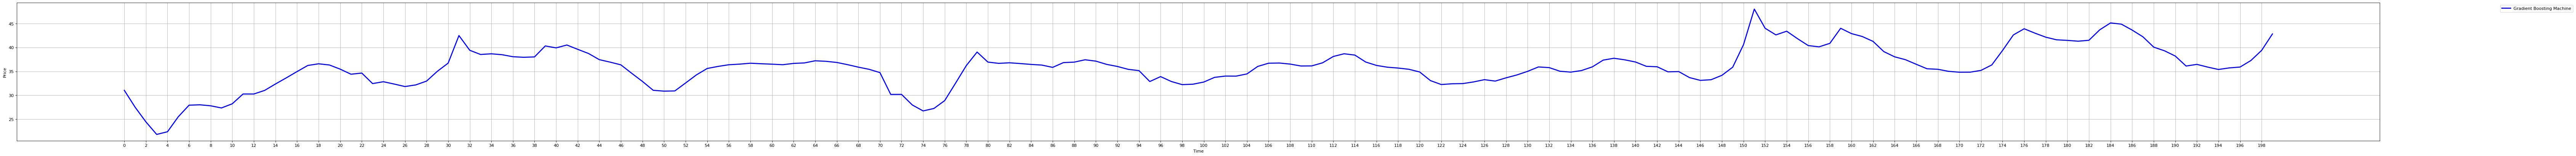

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


hour_ahead = 0



path = "/content/drive/MyDrive/Colab Notebooks/Project/No noise/star_data_set_no_noise.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%m/%d/%Y %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)
First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()

X_temp1 = First['FI']
X_temp2 = First.loc[:, First.columns != 'FI']
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
Pred_index = X.shape
print("Shape = "+str(Pred_index))


plt.figure(figsize=(100, 6), dpi=80)
plt.plot(np.arange(len(Y[0:200])),Y[0:200], color="blue", linewidth=2.5, linestyle="-", label='Gradient Boosting Machine')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(np.arange(0, len(Y[0:200]), 2.0))
plt.grid(linestyle='-')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
